In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer

In [2]:
flights = pd.read_csv('../data/ntsb-sample-2013.csv')

### Drop columns we won't use

In [3]:
# Dropped columns and reasons for dropping them

# Not relevant
flights.drop(['Mkey', 'ReportNo', 'N#', 'SerialNumber', 'ReportType', 'ReportStatus', 'RepGenFlag', 
              'MostRecentReportType', 'OriginalPublishedDate', 'DocketOriginalPublishedDate', 
              'Operator', 'EventID', 'NtsbNo', 'DocketUrl', 'ReportUrl'], axis=1, inplace=True)

# (Almost) all rows have same value
flights.drop(['Country', 'Mode', 'HasSafetyRec', ], axis=1, inplace=True)

# Redundant
flights.drop(['HighestInjuryLevel'], axis=1, inplace=True)

#### Possible issues with other variables

Redundancy: 
- FatalInjuryCount + SeriousInjuryCount + MinorInjuryCount = OnboardInjuryCount + OnGroundInjuryCount
- City, State, Latitude, Longitude, AirportID, AirportName

Requires significant processing:
- ProbableCause, Findings
- Make, Model (hundreds of distinct values)
- PurposeOfFlight (26 distinct values, 17 of which have < 1% occurrence rate)

Possible data leakage
- EventType (accident vs. incident)

#### Preliminary recommendations (C.J.)
- Drop location column unless it's necessary for train/test split
- Drop make + model column
- Investigate meanings of entries in PurposeOfFlight column, group into smaller categories
- Make dummies for the following:
    - AirCraftDamage
    - WeatherCondition
    - BroadPhaseOfFlight
    - AmateurBuilt
- Deal with rows involving multiple aircraft (identifiable by two comma-separated values in a single cell), 
    - Drop these rows for predictive purposes, but need to include them for descriptive purposes (e.g. aggregating injuries in a year).

### Aggregate by date

In [4]:
flights.index = pd.to_datetime(flights['EventDate'])

In [5]:
# Make dummies for AirCraftDamage
# For rows with a comma in AirCraftDamage (indicating a 2-plane crash),
# Count the damage to both planes separately
# E.g. if AirCraftDamage is 'Substantial, Destoryed'
# then set AirCraftDamage_Substantial and AirCraftDamage_Destoryed both to 1

# Switch NA to '' so it can be concatenated below
flights.loc[flights['AirCraftDamage'].isna(), 'AirCraftDamage'] = ''

# Get names of the dummy variable columms
damage_col_names = ['AirCraftDamage_' + category for category in flights['AirCraftDamage'].unique()]

# Get dummy columns
flights = pd.get_dummies(flights, columns=['AirCraftDamage'], dtype=int)

# Drop dummy column corresponding to blank entries
flights.drop(columns=['AirCraftDamage_'], axis=1, inplace=True)


# The following code absorbs the dummy variable for multi-plane crashes into 
# the dummy variables for the individual damage categories

damage_categories = ['Substantial', 'Destroyed', 'Minor']

# Loop over pairs of (category, category)
for cat_1 in damage_categories:
    for cat_2 in damage_categories:

        # Locate dummy variable corresponding to plane 1 in cat_1, plane 2 in cat_2
        col_name = 'AirCraftDamage_' + cat_1 + ', ' + cat_2
        if col_name in damage_col_names:

            # Dummy variable for plane 1's damage category absorbs 
            # dummy variable for multi-plane crash
            col_1_name = 'AirCraftDamage_' + cat_1
            flights[col_1_name] += flights[col_name]

            # Dummy variable for plane 2's damage category absorbs 
            # dummy variable for multi-plane crash
            col_2_name = 'AirCraftDamage_' + cat_2
            flights[col_2_name] += flights[col_name]

            # Discard dummy variable for multi-plane crash
            flights.drop(columns=[col_name], axis=1, inplace=True)

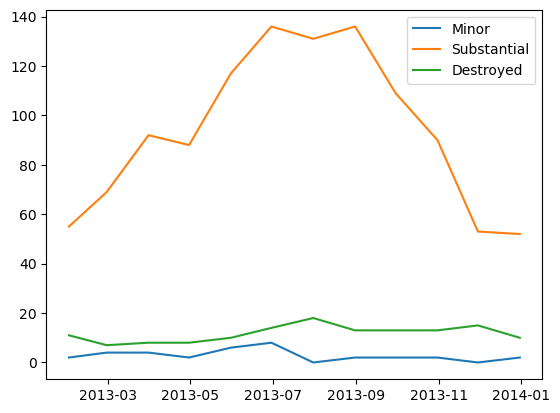

In [6]:
# Aggregate damage

damage_cols = ['AirCraftDamage_Minor', 'AirCraftDamage_Substantial', 'AirCraftDamage_Destroyed']

# Aggregate by month
damage_by_month = flights.groupby(pd.Grouper(freq='ME'))[damage_cols].sum()

plt.plot(damage_by_month, label=['Minor', 'Substantial', 'Destroyed'])
plt.legend()
plt.show()


# Aggregate by year
#injuries_by_year = flights.groupby(pd.Grouper(freq='YE'))[damage_cols].sum()

#plt.plot(injuries_by_year)
#plt.show()

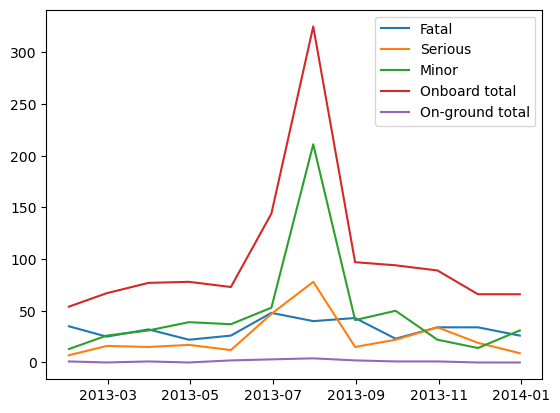

In [7]:
# Aggregate injuries

injury_cols = ['FatalInjuryCount', 'SeriousInjuryCount', 'MinorInjuryCount', 
                  'OnboardInjuryCount', 'OnGroundInjuryCount']

# Aggregate by month
injuries_by_month = flights.groupby(pd.Grouper(freq='ME'))[injury_cols].sum()

plt.plot(injuries_by_month, label=['Fatal', 'Serious', 'Minor', 'Onboard total', 'On-ground total'])
plt.legend()
plt.show()


# Aggregate by year
#injuries_by_year = flights.groupby(pd.Grouper(freq='YE'))[injury_cols].sum()

#plt.plot(injuries_by_year)
#plt.show()

### Make other dummy variables

In [8]:
# Drop rows corresponding to multi-aircraft accidents
# indicated by a comma in the column FAR

# Turn blanks into '' so .contains() works
flights.loc[flights['FAR'].isna(), 'FAR'] = ''

multiple_aircraft = flights['FAR'].str.contains(',')
flights = flights[~multiple_aircraft]

In [9]:
flights = pd.get_dummies(flights, 
                         columns=['AmateurBuilt', 'WeatherCondition','BroadPhaseofFlight'],
                        dtype = int)

### Fill in missing values

- I don't think we need to put anything in for columns we're making into dummy variables; a missing cell just becomes False / 0.0 in every column

In [10]:
# Impute 0 for unknown injury counts

# TODO Figure out how to write an imputer and impute the median instead
flights.loc[flights['OnboardInjuryCount'].isna(), 'OnboardInjuryCount'] = 0
flights.loc[flights['OnGroundInjuryCount'].isna(), 'OnGroundInjuryCount'] = 0
flights['InjuryCount'] = flights['OnboardInjuryCount'] + flights['OnGroundInjuryCount']